<br/>

# Coming up with the best features (Week 10)

Dr Li suggested that I find the top 5 feature-sets recommended to predict DoA using EEG using a linear regression model. However, I tried other models for exploratory purposes.

```python
## Potential features
test_features_A = ['Katz_cA_4', 'SampenCD_2D', 'SampenCD_2DS', 'Katz_cD_1DS']
test_features_B = ['Katz_cA_4', 'SampenCD_2D', 'SampenCA_4DS', 'Katz_cD_1DS']
test_features_C = ['SampenCD_2D', 'SampenCA_4D', 'Katz_cD_2D', 'SampenCD_2DS']
```

<br/>

# Training performance: <code>Support Vector Regression</code>

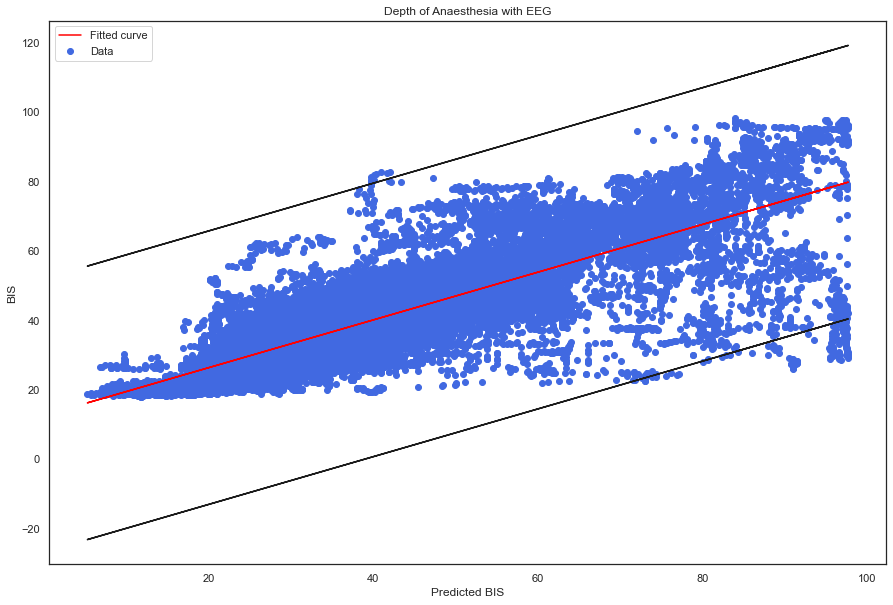

Metrics(r2=0.6581460949755171, mse=124.48627453370149)

<br/>

<br/>

# Testing performance: <code>Support Vector Regression</code>

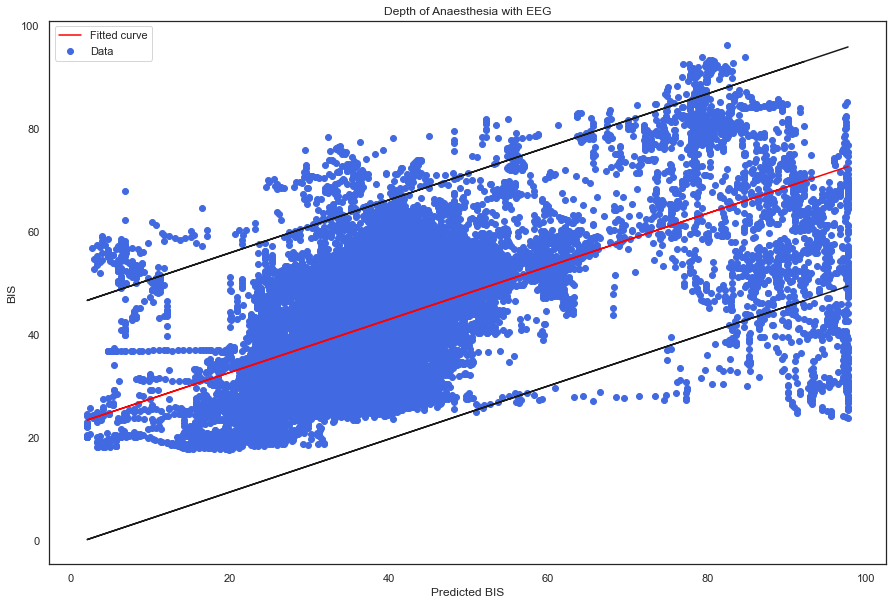

Metrics(r2=0.2555455382100157, mse=168.16365752580583)

<br/>

<br/>

# DoA prediction in test patients

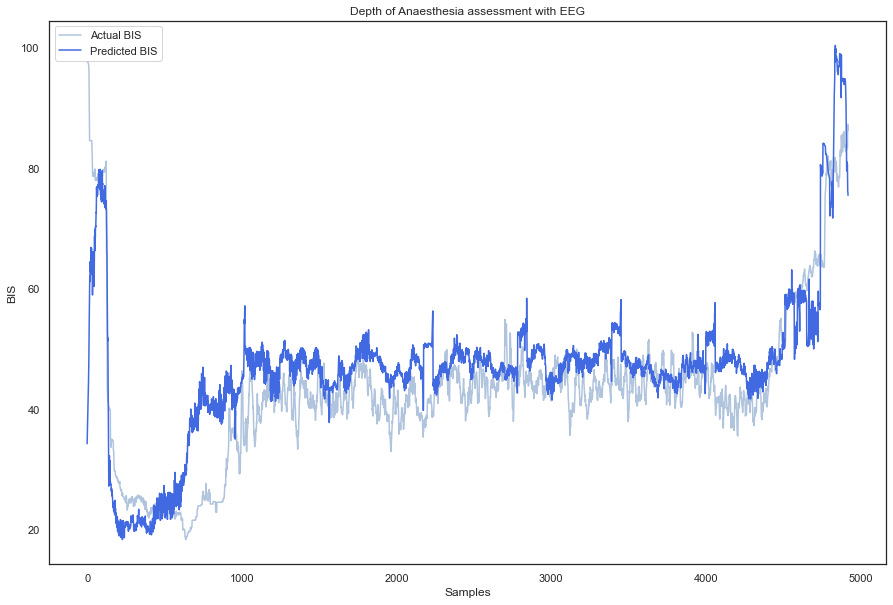

Metrics(r2=0.6335988257242031, mse=60.785810891626426)


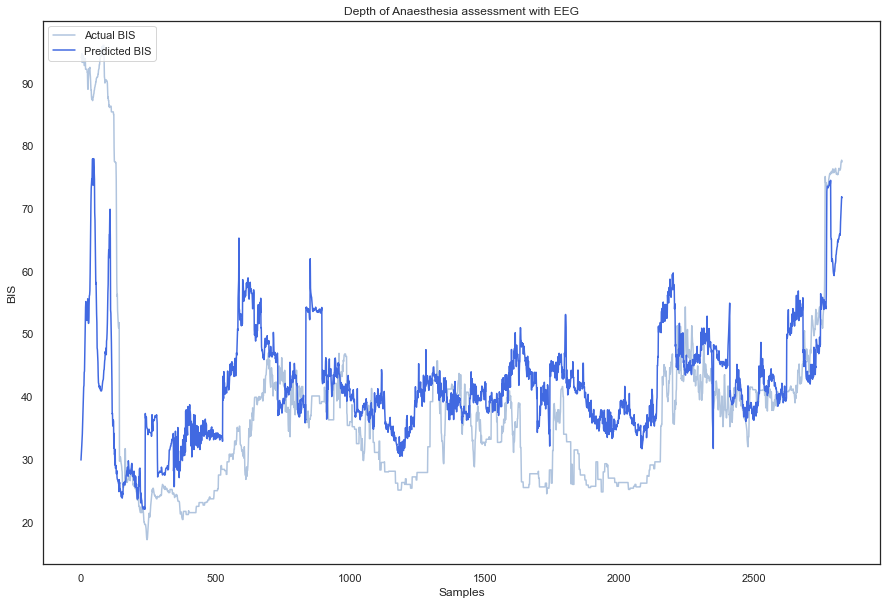

Metrics(r2=0.2432142553401443, mse=173.0580893375456)


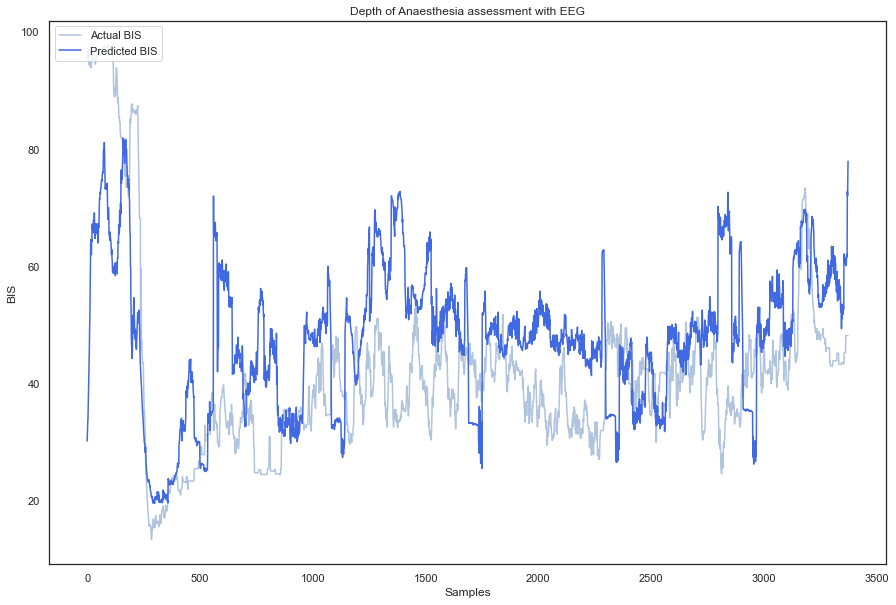

Metrics(r2=0.04522697433103784, mse=237.64320073897673)


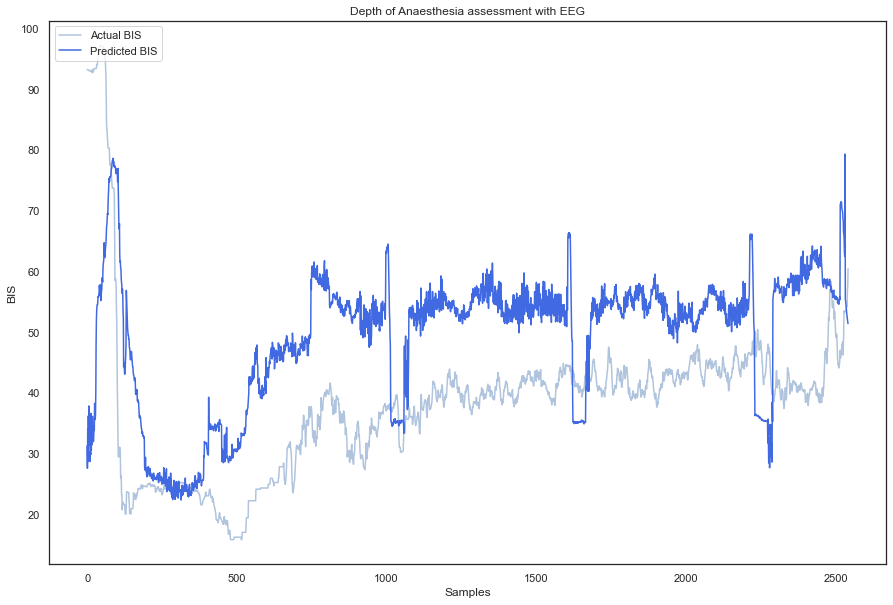

Metrics(r2=-0.6081535624710468, mse=278.7062261169298)


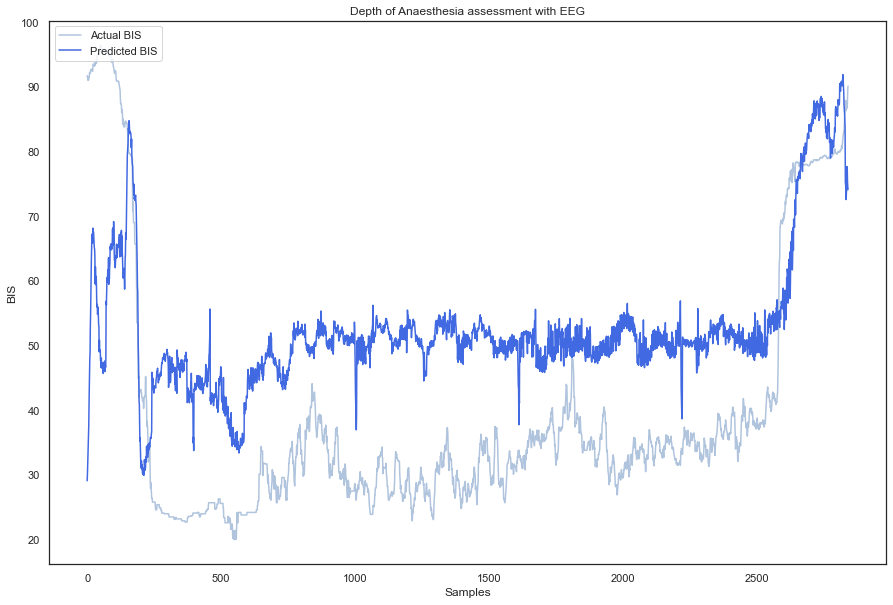

Metrics(r2=0.05733937814871115, mse=354.10625085557)


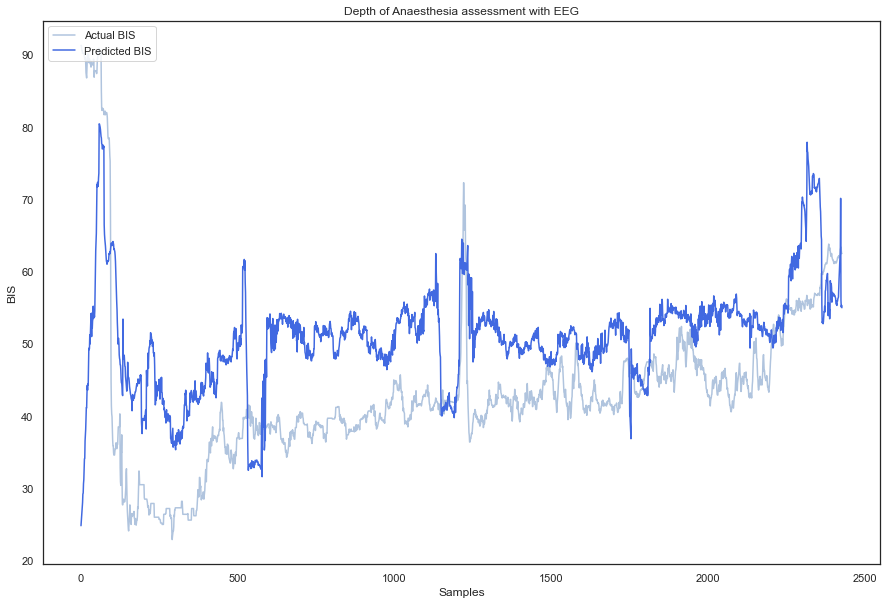

Metrics(r2=-0.20160276798904242, mse=162.23171356686248)


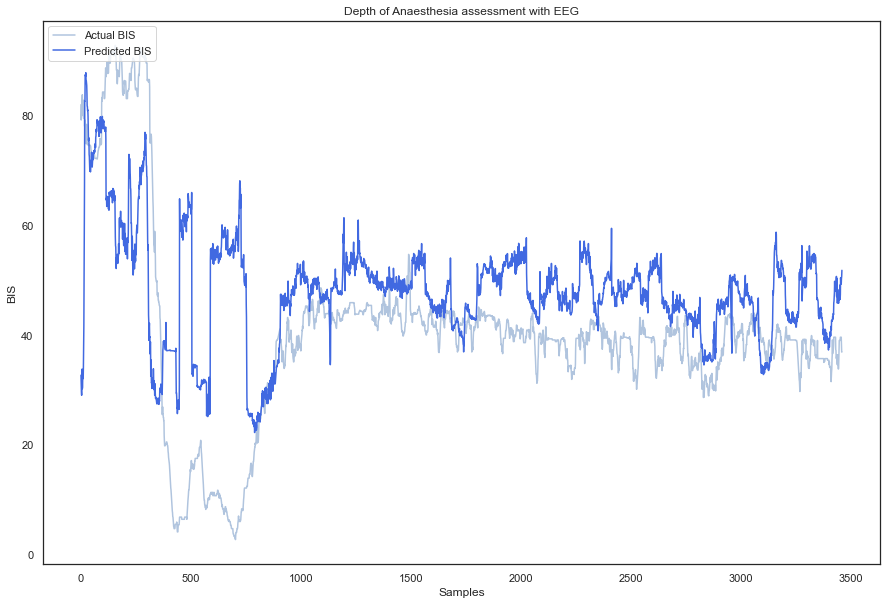

Metrics(r2=0.01870091827172049, mse=300.87175641420805)


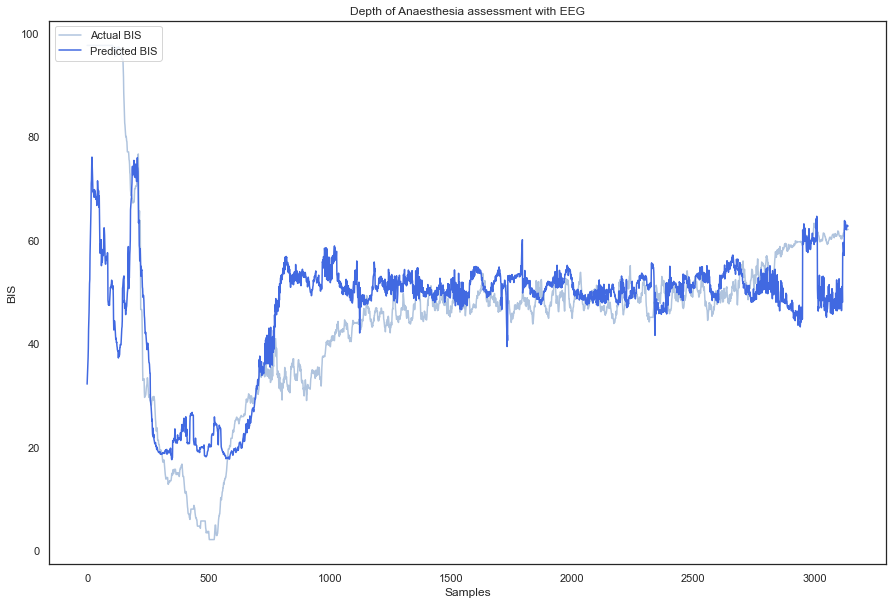

Metrics(r2=0.477962093083277, mse=170.21884696696705)


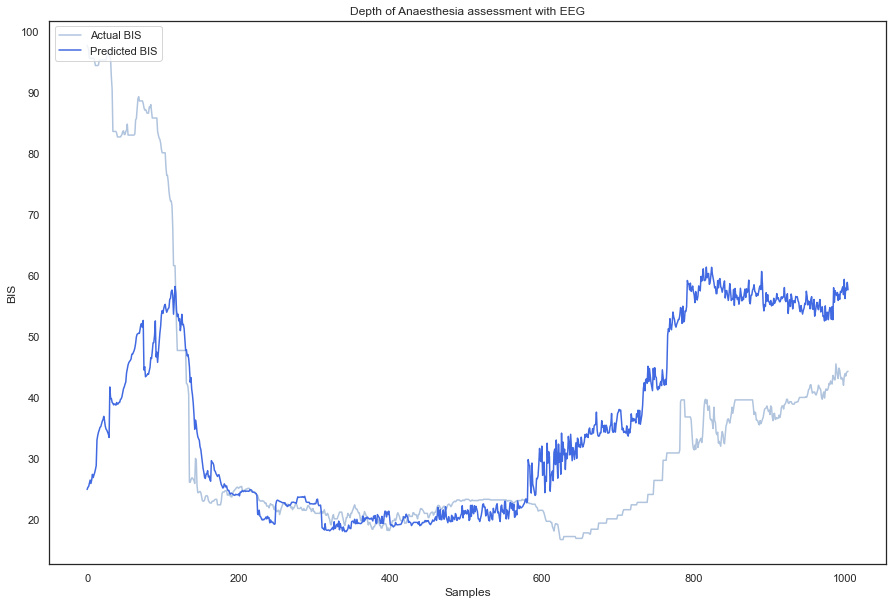

Metrics(r2=0.1486701224788649, mse=366.7097908099181)


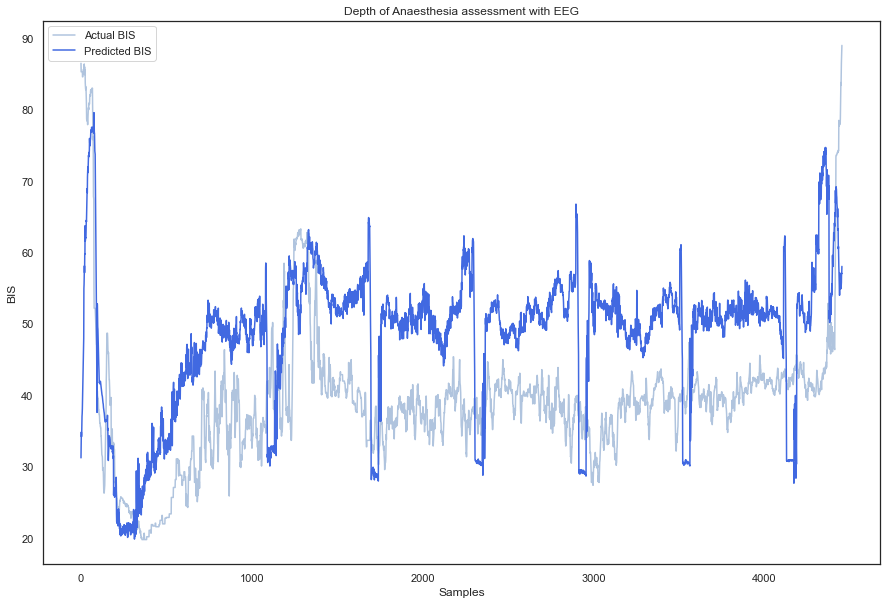

Metrics(r2=-0.9525837230037306, mse=181.31010596581385)


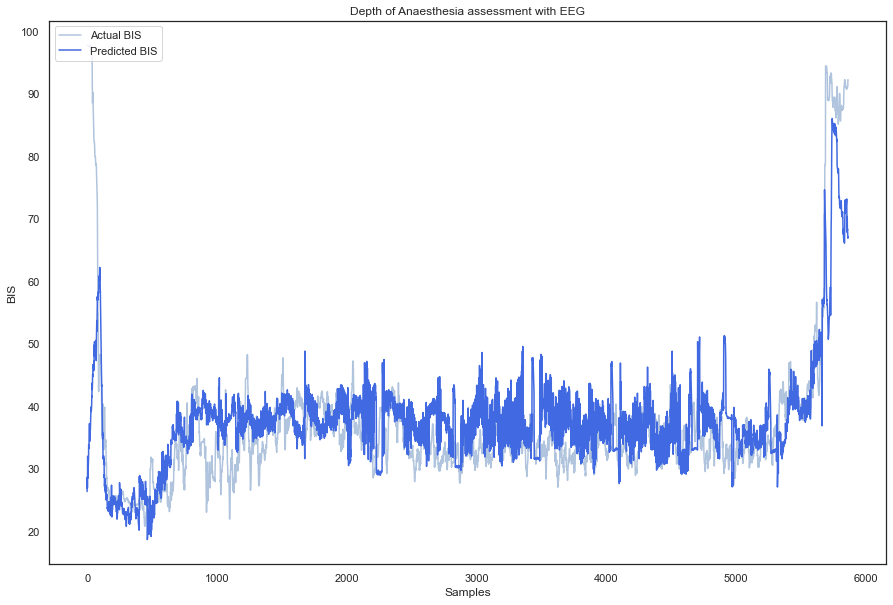

Metrics(r2=0.5086077195216812, mse=76.4805735654369)


<br/>